In [16]:
!jupyter-nbconvert --to python --template python_clean Plugin.ipynb

[NbConvertApp] Converting notebook Plugin.ipynb to python
[NbConvertApp] Writing 9422 bytes to Plugin.py


In [2]:
import logging
import hashlib
import time
from epdlib import Layout

In [3]:
logger = logging.getLogger(__name__)

In [4]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
        @strict_enforce(type1, type2, (type3, type4))
        def foo(val1, val2, val3):
            ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [13]:
class Plugin:
    '''Plugin class for creating and managing plugins'''
    def __init__(self, resolution, name=None, 
                 layout={}, 
                 update_function=None, 
                 max_priority=-1,
                 refresh_rate=60, 
                 min_display_time=30, 
                 config={},
                 cache=None,
                 **kwargs):
        '''Create a plugin object that provides consistent methods for providing an image and querying
        various services
        
        Args:
            resolution(`tuple` of `int`): resolution of the epd or similar screen: (Length, Width)
            name(`str`): human readable name of the function for logging and reference
            layout(`dict`): epdlib.Layout.layout dictionary that describes screen layout
            update_function(func): function that returns plugin status, data and priority a
                update_function must accept (self, *args, **kwargs) and must return
                a tuple of (is_updated(bool), data(dict), priority(int))
            max_priority(`int`): maximum priority for this module values approaching 0 have highest
                priority, values < 0 are inactive
            refresh_rate(`int`): minimum time in seconds between requests for pulling an update
            min_display_time(`int`): minimum time in seconds plugin should be allowed to display in the loop
            config(`dict`): any kwargs that update function requires
            cache(`CacheFiles` obj): object that can be used for downloading remote files and caching
            kwargs(): any additional kwargs will be ignored
            '''
        self.name = name
        if resolution:
            self.resolution = resolution
        
        self.layout = layout
        
#         if update_function:
#             self._add_update_function(update_function)
#         else:
# #             self.update_function = print('no update function set')
#             pass
        self.update_function = update_function
    
        self.max_priority = max_priority
        
        self.refresh_rate = refresh_rate
        self.min_display_time = min_display_time
        
        self.config = config

        self.cache = cache
        
        self._last_ask = 0
        self.hash = self._generate_hash()
        self.data = {}
        self.image = None
        self.priority = -1
    
    @property
    def name(self):
        '''name of plugin
        name(`str`)'''
        return self._name
    
    @name.setter
    def name(self, name):
        self._name = str(name)
        
    @property
    def resolution(self):
        '''resolution of attached screen that will be used for output
            resolution(`tuple` of `int`)'''
        return self._resolution
        
    @resolution.setter
    @strict_enforce((list, tuple))
    def resolution(self, resolution):
        self._resolution = resolution    
    
    @property
    def layout(self):
        '''epdlib.Layout.layout dictionary used for configuring text and image blocks
            layout(`dict`)'''
        return self.layout_obj.layout
    
    @layout.setter
    @strict_enforce(dict)
    def layout(self, layout):
        self.layout_obj = Layout(resolution=self.resolution, layout=layout)
        
    
    @property
    def update_function(self):
        '''update function provided by the plugin module
        
        The update_function is called by the update method to provide status and data for 
        the Plugin.
        
        Args:
            function(function): function that accepts self, *args, **kwargs
            
        Returns:
            tuple of is_updated(bool), data(dict), priority(int)'''
        return self._update_function
    
    @update_function.setter
    def update_function(self, function):
        if not function:
            self._update_function = None
        else:
            self._update_function = function.__get__(self)
    
    @property
    def cache(self):
        '''CacheFiles object used for caching remote files used by plugins
        cache(`CacheFiles` obj)'''
        return self._cache
    
    @cache.setter
    def cache(self, cache):
        if cache:
            self._cache = cache
        else:
            self._cache = None
    
    @property
    def last_ask(self):
        '''Records monotonic time of last time an update function was called 
            This is used by the self._is_ready() function to throttle update requests'''
        return self._last_ask
    
    @last_ask.setter
    def last_ask(self, last_ask):
        self._last_ask = last_ask
        
    
#     def _add_update_function(self, function):
#         '''private function for adding update_functions properly to class'''
#         self.update_function = function.__get__(self)
        
    def _generate_hash(self):
        '''generate a hash based on the self.name and the current time
            This is updated whenever self.data is updated and can be checked as a 
            proxy for "new data"'''
        my_hash = hashlib.sha1()
        my_hash.update(str(time.time()).encode('utf-8')+str(self.name).encode('utf-8'))
        return my_hash.hexdigest()[:10]        
    
    def _is_ready(self):
        '''simple throttle of update requests
            Checks time between current request (monotonic) and self._last_ask and compares to 
            self.refresh_rate
        
        Returns:
            `bool`: True if cooldown period has expired, false otherwise'''
        if time.monotonic() - self._last_ask > self.refresh_rate:
            self._last_ask = time.monotonic()
            return True
        else:
            logging.debug(f'throttling in effect -- wait for {self.refresh_rate - (time.monotonic() - self._last_ask)} seconds before requesting update')
            return False
        
    def update(self, *args, **kwargs):
        '''request an update of the plugin data
            requests are throttled if they occur sooner than the cool-down period
            defined by self.refresh_rate
            
            Returns:
                self.hash(hash of time and self.name)
            
            calls self.update_function(*args, **kwargs):
                self.update_function returns: (`tuple` of `bool`, `dict`, `int`): 
                    bool(true when plugin is updated) 
                    dict(data returned from plugin update_function to be passed into a layout)
                    int(priority of this module; values approaching 0 are highest, negative
                        values indicate plugin is inactive)

            
            Set here:
                self.data
                self.layout_obj.update_contents(self.data)
                self.hash'''
        if self._is_ready():
            is_updated, data, priority = self.update_function(*args, **kwargs)
            if data != self.data:
                self.data = data
                self.layout_obj.update_contents(data)
                self.image = self.layout_obj.concat()
                self.hash = self._generate_hash()
            # always update the priority    
            self.priority = priority
        else:
            pass
        
            
        return self.hash
    

In [14]:
def main():
    '''demo of Plugin data type'''
    from random import randint
    from IPython.display import display
    from time import sleep
    bogus_layout = {
        'number': {
            'image': None,
            'max_lines': 1,
            'width': 1,
            'height': 1,
            'abs_coordinates': (0, 0),
            'rand': True,
            'font': '../fonts/Dosis/Dosis-VariableFontwght.ttf',
        },
    }

    # update_function that is added to the plugin as the method self.update_function
    def bogus_plugin(self):
        data = {'number': str(randint(99,9999))}
        priority = self.max_priority
        is_updated = True

        return (is_updated, data, priority) 


    p = Plugin(resolution=(300, 210), 
               refresh_rate=3, 
               max_priority=1, 
#                update_function=bogus_plugin, 
               layout=bogus_layout)
    
    Plugin.update_function = bogus_plugin
    
    logger.root.setLevel('DEBUG')
    print('this demo is best run from inside jupyter notebook')
    for i in range(100):
        print('trying to update plugin')
        p.update()
        print('displaying image')
        display(p.image)
        print('sleep for 1 second')
        sleep(1)

DEBUG:root:creating layout
DEBUG:root:calculating layout for resolution (300, 210)
DEBUG:root:layout id(2953320128)
DEBUG:root:*****number*****
DEBUG:root:checking layout keys
DEBUG:root:adding key: padding: 0
DEBUG:root:adding key: hcenter: False
DEBUG:root:adding key: vcenter: False
DEBUG:root:adding key: inverse: False
DEBUG:root:adding key: relative: False
DEBUG:root:adding key: font_size: None
DEBUG:root:adding key: maxchar: None
DEBUG:root:adding key: dimensions: None
DEBUG:root:adding key: scale_x: None
DEBUG:root:adding key: scale_y: None
DEBUG:root:dimensions: (300, 210)
DEBUG:root:section has absolute coordinates
DEBUG:root:coordinates: (0, 0)
DEBUG:root:calculating maximum font size for area: (300, 210)
DEBUG:root:using font: /home/pi/src/epd_display/paperpi/fonts/Dosis/Dosis-VariableFontwght.ttf
DEBUG:root:target X font dimension 352.94117647058823
DEBUG:root:target Y font dimension 157.5
DEBUG:root:X target reached
DEBUG:root:test string: W W W ; pixel dimensions for font

this demo is best run from inside jupyter notebook
trying to update plugin
displaying image


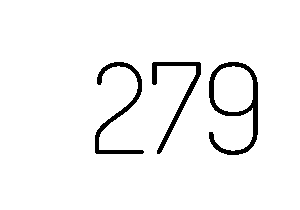

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9553339250001045 seconds before requesting update


trying to update plugin
displaying image


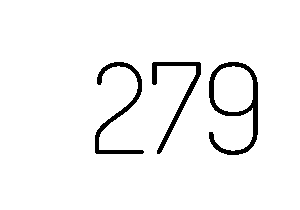

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.9361356669999168 seconds before requesting update


trying to update plugin
displaying image


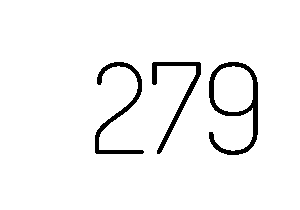

sleep for 1 second


INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 7835
DEBUG:root:formatted list:
 ['7835']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 232, 130
DEBUG:root:max x dim so far: 232
DEBUG:root:dimensions of text portion of image: (232, 130)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 232, 130
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 14, 35
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


trying to update plugin
displaying image


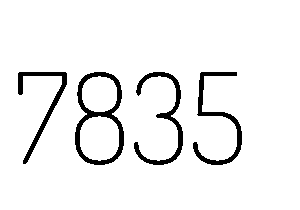

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9240751869999713 seconds before requesting update


trying to update plugin
displaying image


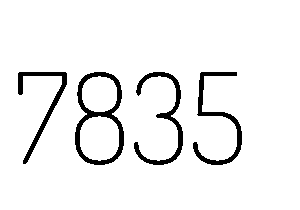

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.9046035900000788 seconds before requesting update


trying to update plugin
displaying image


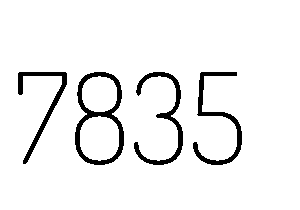

sleep for 1 second


INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 3623
DEBUG:root:formatted list:
 ['3623']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 239, 130
DEBUG:root:max x dim so far: 239
DEBUG:root:dimensions of text portion of image: (239, 130)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 239, 130
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 57, 22
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


trying to update plugin
displaying image


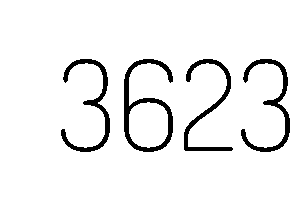

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9298182869999891 seconds before requesting update


trying to update plugin
displaying image


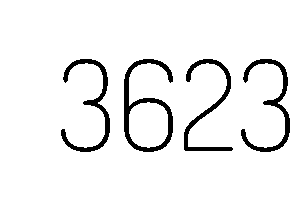

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.9102941270000429 seconds before requesting update


trying to update plugin
displaying image


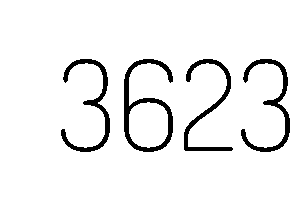

sleep for 1 second


INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 6380
DEBUG:root:formatted list:
 ['6380']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 248, 130
DEBUG:root:max x dim so far: 248
DEBUG:root:dimensions of text portion of image: (248, 130)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 248, 130
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 3, 23
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


trying to update plugin
displaying image


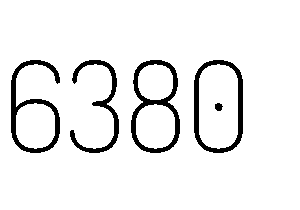

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9206457830000545 seconds before requesting update


trying to update plugin
displaying image


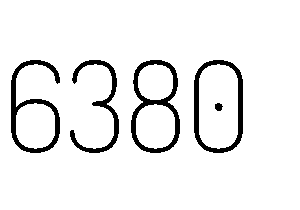

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.9011193369999546 seconds before requesting update


trying to update plugin
displaying image


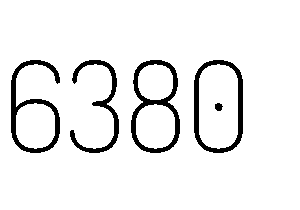

sleep for 1 second


INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 4313
DEBUG:root:formatted list:
 ['4313']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 196, 130
DEBUG:root:max x dim so far: 196
DEBUG:root:dimensions of text portion of image: (196, 130)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 196, 130
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 5, 47
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


trying to update plugin
displaying image


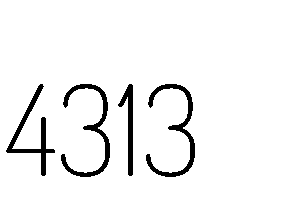

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9154247819999455 seconds before requesting update


trying to update plugin
displaying image


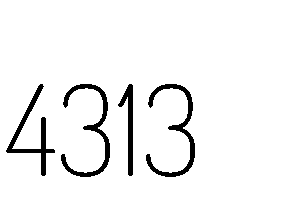

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.8961863069998799 seconds before requesting update


trying to update plugin
displaying image


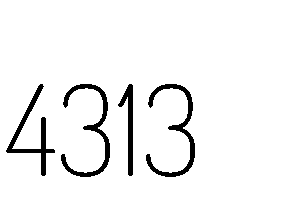

sleep for 1 second


INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 7417
DEBUG:root:formatted list:
 ['7417']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 188, 129
DEBUG:root:max x dim so far: 188
DEBUG:root:dimensions of text portion of image: (188, 129)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 188, 129
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 66, 12
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


trying to update plugin
displaying image


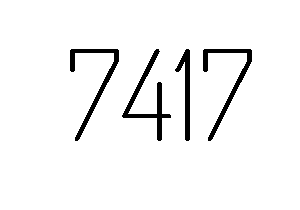

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9327716450000025 seconds before requesting update


trying to update plugin
displaying image


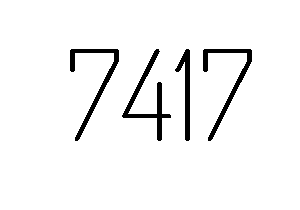

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 0.9144033580000723 seconds before requesting update


trying to update plugin
displaying image


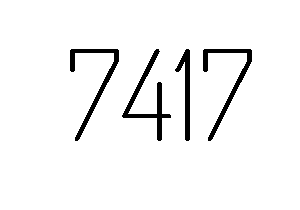

sleep for 1 second


INFO:root:updating blocks
DEBUG:root:updating block: number
DEBUG:root:formatting string: 8128
DEBUG:root:formatted list:
 ['8128']
DEBUG:root:creating blank image area: (300, 210) with inverse: False
DEBUG:root:line size: 206, 130
DEBUG:root:max x dim so far: 206
DEBUG:root:dimensions of text portion of image: (206, 130)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 206, 130
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 17, 47
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **number** image at: (0, 0)


trying to update plugin
displaying image


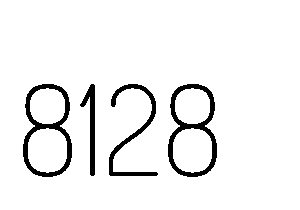

sleep for 1 second


DEBUG:root:throttling in effect -- wait for 1.9133342159998392 seconds before requesting update


trying to update plugin
displaying image


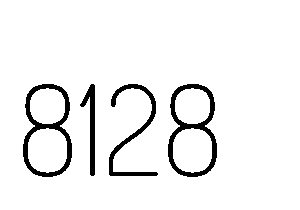

sleep for 1 second


KeyboardInterrupt: 

In [15]:
if __name__ == '__main__':
    main()